In [1]:
import csv
from datetime import timedelta
import gurobipy as gp 
from gurobipy import GRB
import networkx as nx
import random
import matplotlib.pyplot as plt
import inspect
from collections import defaultdict

from models import simple_mpc, mpc_duration_constr, lazy, column_generation, updated_mpc_duration_constr
from helper import Service, hhmm2mins, mins2hhmm, fetch_data, draw_graph_with_edges, node_legal, no_overlap, create_duty_graph, extract_nodes, generate_paths, roster_statistics, solution_verify, solve_RMLP, new_duty_with_bellman_ford, count_overlaps, solve_MIP, new_duty_with_RCSP, new_duty_with_RCSP_priority, updated_new_duty_with_RCSP_priority

In [2]:
import importlib
import models
import helper

importlib.reload(models)
importlib.reload(helper)

from models import simple_mpc, mpc_duration_constr, lazy, column_generation, updated_mpc_duration_constr
from helper import Service, hhmm2mins, mins2hhmm, fetch_data, draw_graph_with_edges, node_legal, no_overlap, create_duty_graph, extract_nodes, generate_paths, roster_statistics, solution_verify, solve_RMLP, new_duty_with_bellman_ford, count_overlaps, solve_MIP, updated_new_duty_with_RCSP_priority

In [ ]:
services, service_dict = fetch_data('./StepBackServices.csv', partial=False, rakes = 30)       # 46 maximum number of rakes
graph = create_duty_graph(services)
print(graph)

DiGraph with 936 nodes and 140958 edges


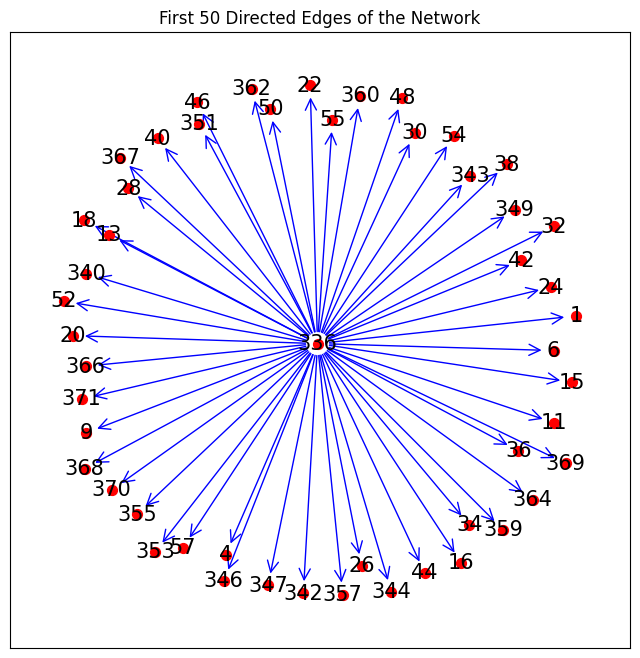

In [ ]:
draw_graph_with_edges(graph)

In [ ]:
init_duties, duty_count = mpc_duration_constr(graph, service_dict,max_duty_duration=6*60, time_limit = 60,  show_logs = False, show_duties = False, show_roster_stats = False)
# init_duties, duty_count = updated_mpc_duration_constr(graph, service_dict,max_drive_duration=6*60,max_duty_duration=8*60, time_limit = 65,  show_logs = False, show_duties = False, show_roster_stats = False)

# init_duties, duty_count = simple_mpc(graph, service_dict, show_logs=False)
print(f"Initial number of duties: {len(init_duties)}")
cutoff_obj = len(init_duties)
print("For MPC method:", "\n")
all_covered = count_overlaps(init_duties, services)
print("\n")
init_duties2 = init_duties.copy()
threshold = -0.1;  # threshold for reduced cost
# //////////////////// rmlp +lp + rcsp/////////////////////////////////////
for _ in range(100000):
# _ = 0
# while True:
#     _ += 1
    selected_duties, duals, selected_duty_vars, obj = solve_RMLP(duties=init_duties2, services=services)
    # path, length, graph_cp = new_duty_with_bellman_ford(graph, duals)
    max_duty_duration = 8* 60 # 8 hours
    path, cost, label_info = updated_new_duty_with_RCSP_priority(graph, duals, service_dict, max_resource=max_duty_duration)
    # path, cost, label_info = new_duty_with_RCSP(graph, duals, service_dict, max_resource=max_duty_duration)

    # Check for LP convergence: if the new column's cost is above (or near) the threshold,
    # then we consider that no significant improvement is possible.
    if cost >= threshold:
        print("LP converged: Reduced cost has reached the threshold (>= -0.1)")
        break
    # print(_, obj, length, path)
    print(_, obj, cost, path)
    if path[1:-1] in init_duties2:
        break
    init_duties2.append(path[1:-1])

print("num of duties after lp", len(init_duties2))
print(f"iteration number {_} breaks......")
print("IP starts solving.......")
# //////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
# incumbent_solution = [i for i in range(len(init_duties2))]  # or a subset based on your heuristic
# obj, selected_duties, model = solve_MIP(services, duties=init_duties2, incumbent_duties=incumbent_solution,
#                                         cutoff=cutoff_obj, mipgap=0.01, timelimit=60*6)
# # ///////////////////////////////////////////// IP starts solving ///////////////////////////////////////////////////////


obj, selected_duties, model = solve_MIP(services, duties=init_duties2, cutoff=cutoff_obj, mipgap=0.01, timelimit=60*6)
# obj, selected_duties, model = solve_MIP(services, duties=init_duties2,service_dict= service_dict, cutoff=cutoff_obj, mipgap=0.01, timelimit=60*6)

if selected_duties is None:
    print("No valid solution was found. Model status:", model.status)
else:
    tt = []
    for duty_num in selected_duties:
        tt.append(init_duties2[duty_num])
    count_overlaps(tt, services)





Initial number of duties: 133
For MPC method: 

Number of duties selected: 133
Total number of services: 934
Number of services that overlap in duties: 0
Number of services covered in duties: 934


0 133.0 -14.0 [-2, 926, 928, 3, 349, 360, 376, 384, 400, 429, 436, 447, 457, 472, 912, 913, -1]
1 133.0 -13.0 [-2, 527, 929, 698, 17, 367, 375, 403, 425, 435, 442, 455, 479, 912, 913, -1]
2 133.0 -13.0 [-2, 927, 695, 701, 712, 720, 733, 755, 767, 778, 801, 819, 826, 833, -1]
3 133.0 -11.0 [-2, 336, 340, 346, 30, 746, 762, 152, 445, 454, 486, 912, 913, -1]
4 133.0 -11.0 [-2, 337, 342, 16, 45, 406, 430, 444, 452, 460, 484, 295, -1]
5 133.0 -12.0 [-2, 872, 693, 700, 23, 377, 385, 412, 446, 217, 822, 829, 858, -1]
6 133.0 -11.0 [-2, 876, 694, 703, 717, 62, 90, 768, 785, 218, 475, 482, -1]
7 133.0 -10.0 [-2, 345, 22, 89, 185, 810, 817, 262, 287, 323, -1]
8 133.0 -11.0 [-2, 878, 696, 704, 717, 724, 112, 188, 238, 273, 854, -1]
9 133.0 -12.0 [-2, 877, 0, 702, 717, 731, 745, 120, 149, 803, 818, 847,

In [ ]:
# //////////////////// rmlp +lp + rcsp/////////////////////////////////////
init_duties2 = init_duties.copy()
threshold = -0.1;  # threshold for reduced cost
for _ in range(100000):
# _ = 0
# while True:
#     _ += 1
    selected_duties, duals, selected_duty_vars, obj = solve_RMLP(duties=init_duties2, services=services)
    # path, length, graph_cp = new_duty_with_bellman_ford(graph, duals)
    max_duty_duration = 6* 60 # 6 hours
    # path, cost, label_info = updated_new_duty_with_RCSP_priority(graph, duals, service_dict, max_resource=max_duty_duration)
    # path, cost, label_info = new_duty_with_RCSP_priority(graph, duals, service_dict, max_resource=max_duty_duration)
    path, cost, label_info = new_duty_with_RCSP(graph, duals, service_dict, max_resource=max_duty_duration)

    # Check for LP convergence: if the new column's cost is above (or near) the threshold,
    # then we consider that no significant improvement is possible.
    if cost >= threshold:
        print("LP converged: Reduced cost has reached the threshold (>= -0.1)")
        break
    # print(_, obj, length, path)
    print(_, obj, cost, path)
    if path[1:-1] in init_duties2:
        break
    init_duties2.append(path[1:-1])

print("num of duties after lp", len(init_duties2))
print(f"iteration number {_} breaks......")
print("IP starts solving.......")
# //////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
# incumbent_solution = [i for i in range(len(init_duties2))]  # or a subset based on your heuristic
# obj, selected_duties, model = solve_MIP(services, duties=init_duties2, incumbent_duties=incumbent_solution,
#                                         cutoff=cutoff_obj, mipgap=0.01, timelimit=60*6)
# # ///////////////////////////////////////////// IP starts solving ///////////////////////////////////////////////////////


obj, selected_duties, model = solve_MIP(services, duties=init_duties2, cutoff=cutoff_obj, mipgap=0.01, timelimit=60*6)
# obj, selected_duties, model = solve_MIP(services, duties=init_duties2,service_dict= service_dict, cutoff=cutoff_obj, mipgap=0.01, timelimit=60*6)

if selected_duties is None:
    print("No valid solution was found. Model status:", model.status)
else:
    tt = []
    for duty_num in selected_duties:
        tt.append(init_duties2[duty_num])
    count_overlaps(tt, services)


0 898.0 -24.0 [-2, 926, 532, 534, 537, 541, 545, 549, 553, 557, 561, 565, 569, 573, 620, 623, 627, 631, 635, 639, 643, 647, 651, 655, 659, -1]
1 875.0 -23.0 [-2, 532, 534, 537, 541, 545, 549, 553, 557, 561, 565, 569, 573, 620, 623, 627, 631, 635, 639, 643, 647, 651, 655, 659, -1]
2 875.0 -23.0 [-2, 529, 533, 535, 539, 543, 547, 551, 555, 559, 563, 567, 571, 620, 623, 627, 631, 635, 639, 643, 647, 651, 655, 659, -1]
3 875.0 -23.0 [-2, 529, 532, 534, 537, 541, 545, 549, 553, 557, 561, 565, 569, 573, 621, 625, 629, 633, 637, 641, 645, 649, 653, 657, -1]
4 864.5 -24.0 [-2, 926, 530, 533, 535, 539, 543, 547, 551, 555, 559, 563, 567, 571, 621, 625, 629, 633, 637, 641, 645, 649, 653, 657, 680, -1]
5 853.0 -22.0 [-2, 529, 531, 536, 540, 544, 548, 552, 556, 560, 564, 568, 572, 620, 624, 628, 632, 636, 640, 644, 648, 652, 656, -1]
6 853.0 -23.0 [-2, 529, 532, 534, 537, 541, 545, 549, 553, 557, 561, 565, 569, 572, 623, 627, 631, 635, 639, 643, 647, 651, 655, 659, -1]
7 842.5 -23.0 [-2, 530, 532, 

KeyboardInterrupt: 

In [ ]:
l =[ 912]
totservicehr =0
for serv in l:
    totservicehr += service_dict[serv].serv_dur
print(totservicehr)

In [ ]:
print("num of duties after lp", len(init_duties2))
obj, selected_duties, model = solve_MIP(services, duties=init_duties2, cutoff=cutoff_obj, mipgap=0.001, timelimit=60*6)

tt = []
for duty_num in selected_duties:
    tt.append(init_duties2[duty_num])
count_overlaps(tt, services)

In [ ]:
for duty in init_duties:
    if duty not in tt:
        print(duty)

In [ ]:
xd = init_duties.copy()

In [ ]:
for duty in xd:
    if duty not in init_duties:
        print(duty)

In [ ]:
# To check number of services that overlap in all selected duties
# Run after column generation

for i in range(1, 21, 2):
    tt = 0.01 * i
    init_duties, duty_count = mpc_duration_constr(graph, service_dict, time_limit = 20, show_logs = False, show_duties = False, show_roster_stats = False)
    print(f"Initial number of duties: {len(init_duties)}", "\n", "For MPC method:", "\n")
    all_covered = count_overlaps(init_duties, services)
    print("\n")
    init_duties2 = init_duties.copy()
    objectives, selected_duties, indexes = column_generation(method=1, graph = graph, services = services, init_duties= init_duties2, num_iter = 400, threshold=tt) 
    print(f"Threshold: {tt}")
    all_covered = count_overlaps(selected_duties, services)
    print("\n")
    if not all_covered:
        print("<---------------------Not all services covered in the previous iteration--------------------->")
        break

<h3>For number of rakes = 3</h3>
Threshold: 0.17<br>
Number of duties selected: 18<br>
Total number of services: 64<br>
Number of services that overlap in duties: 55<br>
Number of services covered in duties: 64<br>

<h3>For number of rakes = 4 </h3>
Threshold: 0.15<br>
Number of duties selected: 29<br>
Total number of services: 86<br>
Number of services that overlap in duties: 64<br>
Number of services covered in duties: 86<br>

<h3>For number of rakes = 5 </h3>
Threshold: 0.18<br>
Number of duties selected: 33<br>
Total number of services: 106<br>
Number of services that overlap in duties: 84<br>
Number of services covered in duties: 106<br>

In [ ]:
init_duties, duty_count = mpc_duration_constr(graph, service_dict, time_limit = 10, show_logs = False, show_duties = False, show_roster_stats = False)
print(init_duties)

In [ ]:
# block to write selected duties to csv file

output_filename = "duties_after_gen/duties_after_gen_701_all.csv"

with open(output_filename, mode="w", newline="") as file:
    # Define column headers
    fieldnames = [
        "Service Number", "Train Number", "Start Station", "Start Time (mins)", 
        "End Station", "End Time (mins)", "Direction", "Service Duration", 
        "Jurisdiction", "Stepback Train Number", "Break Duration", "Trip Duration",
        "Duty Duration"  # New column for total duty duration
    ]
    
    writer = csv.writer(file)
    writer.writerow(fieldnames)  # Write header

    for duty in selected_duties:
        # Calculate total duty duration (from first service start time to last service end time)
        valid_services = [service_dict[s] for s in duty if s in service_dict]
        if valid_services:
            duty_start_time = min(s.start_time for s in valid_services)
            duty_end_time = max(s.end_time for s in valid_services)
            total_duty_duration = duty_end_time - duty_start_time

            for service in valid_services:
                writer.writerow([
                    service.serv_num, service.train_num, service.start_stn, service.start_time,
                    service.end_stn, service.end_time, service.direction, service.serv_dur,
                    service.jurisdiction, service.stepback_train_num, service.break_dur, service.trip_dur,
                    total_duty_duration  # Add total duty duration for each service
                ])
        writer.writerow([])  # Add an empty row to separate duties

print(f"CSV file '{output_filename}' generated successfully.")

In [ ]:
# block to calculate duty times

print(indexes)
duty_times = []
for duty in selected_duties:
    duty_time = 0
    for serv in duty:
        for service in services:
            if service.serv_num == serv:
                duty_time += service.serv_dur
                break
    duty_times.append(mins2hhmm(duty_time))
# for i in range(len(selected_duties)):
#     print(selected_duties[i], duty_times[i])


In [ ]:
# block to plot objective values over iterations

iterations = range(1, len(objectives) + 1)

plt.figure(figsize=(10, 6))
plt.plot(iterations, objectives, marker='o', linestyle='--', color='b')
plt.title('Objective Values Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Objective Value')
plt.grid(True)
plt.show()